In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%pip install scikit-posthocs

In [3]:
from scipy import stats
import scikit_posthocs as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf

pd.set_option("display.max_columns", 100)
sns.set(style="whitegrid", font_scale=1.0)

In [4]:
fgp = pd.read_csv("/content/fear_greed_index.csv")
fgp.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [5]:
hd = pd.read_csv("/content/historical_data.csv")
hd.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [6]:
# 2) Load datasets
# The dataframes hd and fgp are already loaded in previous cells.
hl = hd.copy()
fg = fgp.copy()


# Standardize column names: lowercase, underscores
hl.columns = hl.columns.str.strip().str.lower().str.replace(" ", "_")
fg.columns = fg.columns.str.strip().str.lower().str.replace(" ", "_")

# Inspect to align naming if needed
print("HL columns:", hl.columns.tolist()[:30])
print("FG columns:", fg.columns.tolist()[:30])

# Required HL columns (adapt if different)
# Expect: account, symbol, execution_price, size, side, time, start_position, event, closedpnl, leverage
# Fix common variants
rename_variants = {
    "execution price": "execution_price",
    "closedpnl": "closedpnl",
    "closed_pnl": "closedpnl",
    "start position": "start_position",
    "size tokens": "size_tokens", # Correcting size tokens column
    "size usd": "size_usd", # Correcting size usd column
    "side": "side", # Ensure side is handled
    "timestamp_ist": "time", # Use the provided timestamp column as the time column
    "coin": "symbol" # Rename coin to symbol
}
for k, v in rename_variants.items():
    # Removed the condition to ensure renaming occurs
    if k in hl.columns:
        hl.rename(columns={k: v}, inplace=True)

# Add a print statement to check columns after renaming
print("HL columns after renaming:", hl.columns.tolist()[:30])


# Ensure required columns exist after renaming, particularly 'time' and 'symbol'
required_hl_cols = ['account', 'symbol', 'execution_price', 'size_tokens', 'side', 'time', 'start_position', 'closedpnl']
for col in required_hl_cols:
    if col not in hl.columns:
        # Attempt to find close matches or raise a more specific error
        potential_matches = [c for c in hl.columns if col.replace("_", "") in c.replace("_", "")]
        if potential_matches:
             raise ValueError(f"Required Hyperliquid data column '{col}' not found. Potential matches: {potential_matches}")
        else:
            raise ValueError(f"Required Hyperliquid data column '{col}' not found.")


# Parse HL time
hl["time"] = pd.to_datetime(hl["time"], errors="coerce", utc=True)
hl = hl.dropna(subset=["time"]).copy()
hl["trade_date"] = hl["time"].dt.tz_convert("UTC").dt.date

# Keep only executed trades/fills if 'event' present
if "event" in hl.columns:
    mask_fill = hl["event"].astype(str).str.lower().str.contains("fill|trade|execut")
    if mask_fill.any():
        hl = hl[mask_fill].copy()

# Numeric coercion - Using size_tokens and size_usd as size if present
size_col_to_use = None
if "size_tokens" in hl.columns:
    size_col_to_use = "size_tokens"
elif "size_usd" in hl.columns:
    size_col_to_use = "size_usd"

if size_col_to_use:
    hl["size"] = pd.to_numeric(hl[size_col_to_use], errors="coerce")
else:
    # Handle case where neither size_tokens nor size_usd are found - perhaps raise an error or set size to nan
    print("Warning: Neither 'size_tokens' nor 'size_usd' found. Cannot calculate 'size'.")
    hl["size"] = np.nan # Or raise ValueError if size is essential


for c in ["execution_price", "closedpnl", "leverage", "start_position"]:
    if c in hl.columns:
        hl[c] = pd.to_numeric(hl[c], errors="coerce")

# Normalize side
if "side" in hl.columns:
    hl["side"] = hl["side"].astype(str).str.strip().str.title()
    hl["side_binary"] = np.where(hl["side"].eq("Buy"), 1, 0)

# Fear & Greed: parse date and classification
if "date" not in fg.columns:
    raise ValueError("Fear & Greed dataset must include 'date'.")
fg["date"] = pd.to_datetime(fg["date"], errors="coerce", utc=True).dt.date

# Standardize label column
label_col = None
for cand in ["classification", "label", "class", "sentiment"]:
    if cand in fg.columns:
        label_col = cand
        break
if label_col is None:
    raise ValueError("Fear & Greed dataset must include a classification/label column.")

fg["classification"] = fg[label_col].astype(str).str.strip().str.title()

# Map to ordered category and score
order = ["Extreme Fear", "Fear", "Neutral", "Greed", "Extreme Greed"]
fg["classification"] = pd.Categorical(fg["classification"], categories=order, ordered=True)
score_map = {lab: i for i, lab in enumerate(order)}
fg["sentiment_score"] = fg["classification"].map(score_map)

# Deduplicate FG by date if necessary (keep last)
fg = fg.sort_values("date").drop_duplicates(subset=["date"], keep="last")

HL columns: ['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side', 'timestamp_ist', 'start_position', 'direction', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp']
FG columns: ['timestamp', 'value', 'classification', 'date']
HL columns after renaming: ['account', 'symbol', 'execution_price', 'size_tokens', 'size_usd', 'side', 'time', 'start_position', 'direction', 'closedpnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp']


In [7]:
# 3) Merge by UTC date
merged = hl.merge(fg[["date", "classification", "sentiment_score"]],
                  left_on="trade_date", right_on="date", how="left")

coverage = merged["classification"].notna().mean()
print(f"Trades with sentiment coverage: {coverage:.1%}")

Trades with sentiment coverage: 45.3%


In [8]:
# 4) Trade-level features
eps = 1e-9
if "closedpnl" not in merged.columns:
    raise ValueError("Missing 'closedPnL' (closedpnl) in Hyperliquid dataset.")

merged["pnl"] = merged["closedpnl"].astype(float)
merged["pnl_bin"] = (merged["pnl"] > 0).astype(int)
# Normalize by absolute trade size (or notional proxy)
if "size" in merged.columns:
    merged["norm_pnl"] = merged["pnl"] / (merged["size"].abs() + eps)
else:
    merged["norm_pnl"] = np.nan

# 5) Account-day aggregates
group_keys = ["account", "trade_date", "classification", "sentiment_score"]
agg = merged.groupby(group_keys).agg(
    total_trades=("pnl", "count"),
    total_pnl=("pnl", "sum"),
    profit_rate=("pnl_bin", "mean"),
    median_trade_pnl=("pnl", "median"),
    tail_risk=("pnl", lambda x: np.percentile(x.dropna(), 5) if x.notna().any() else np.nan),
    total_size=("size", lambda x: x.abs().sum() if "size" in merged.columns else np.nan),
    avg_trade_size=("size", "mean"),
    buy_ratio=("side_binary", "mean"),
    symbols=("symbol", pd.Series.nunique)
).reset_index()

# Concentration (Herfindahl) by symbol on account-day
def herfindahl(df):
    if "size" not in df.columns or df["size"].abs().sum() == 0:
        return np.nan
    w = df.groupby("symbol")["size"].apply(lambda s: s.abs().sum())
    w = w / (w.sum() + eps)
    return (w**2).sum()

conc = merged.groupby(group_keys).apply(herfindahl).reset_index(name="symbol_concentration")
panel = agg.merge(conc, on=group_keys, how="left")

/tmp/ipython-input-2440964079.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = merged.groupby(group_keys).agg(
/tmp/ipython-input-2440964079.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conc = merged.groupby(group_keys).apply(herfindahl).reset_index(name="symbol_concentration")
/tmp/ipython-input-2440964079.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the

/tmp/ipython-input-394875220.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_sent = panel.groupby("classification").agg(


  classification  accounts  days  med_total_pnl  iqr_total_pnl  \
0   Extreme Fear        32   188            0.0            0.0   
1           Fear        32   188            0.0            0.0   
2        Neutral        32   188            0.0            0.0   
3          Greed        32   188            0.0            0.0   
4  Extreme Greed        32   188            0.0            0.0   

   med_profit_rate  med_norm_trade_pnl  med_buy_ratio  med_trades  
0         0.000000                 0.0       0.752941         0.0  
1         0.338235                 0.0       0.500000         0.0  
2         0.210526                 0.0       0.466667         0.0  
3         0.324000                 0.0       0.555556         0.0  
4         0.247215                 0.0       0.472691         0.0  


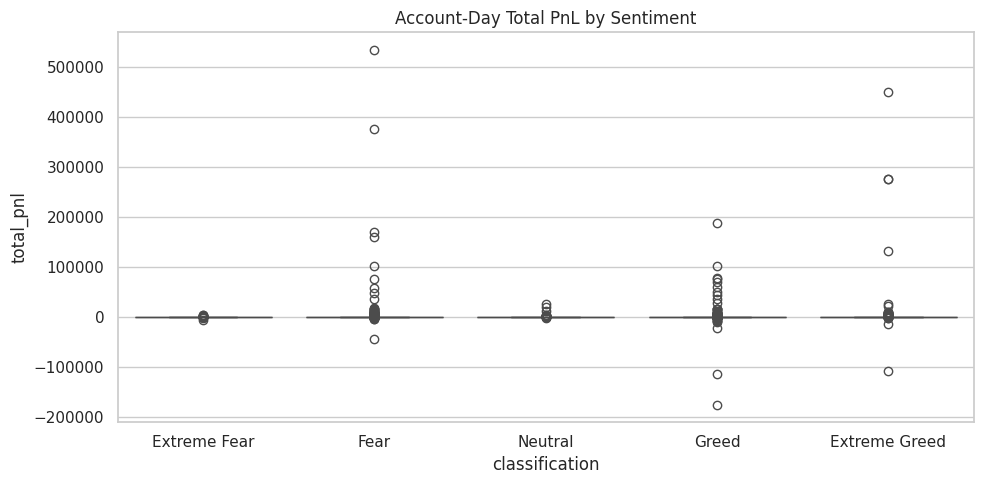

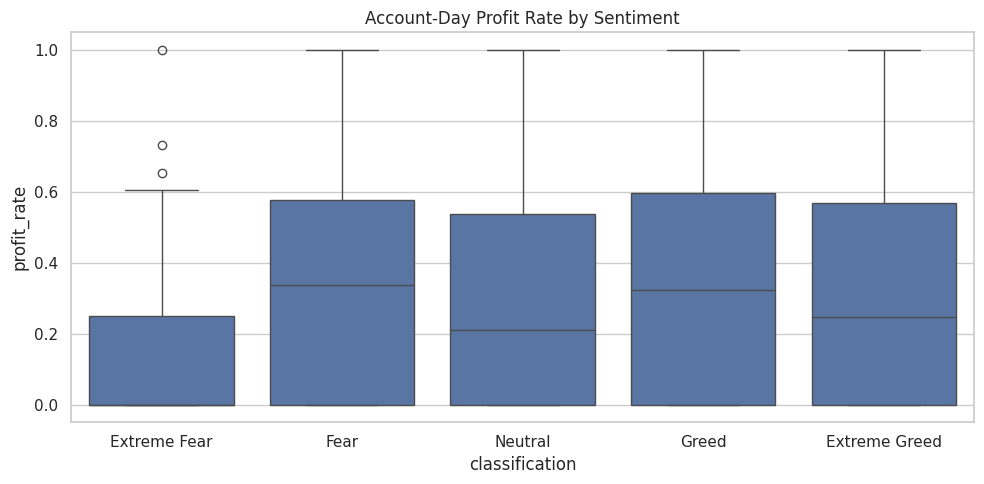

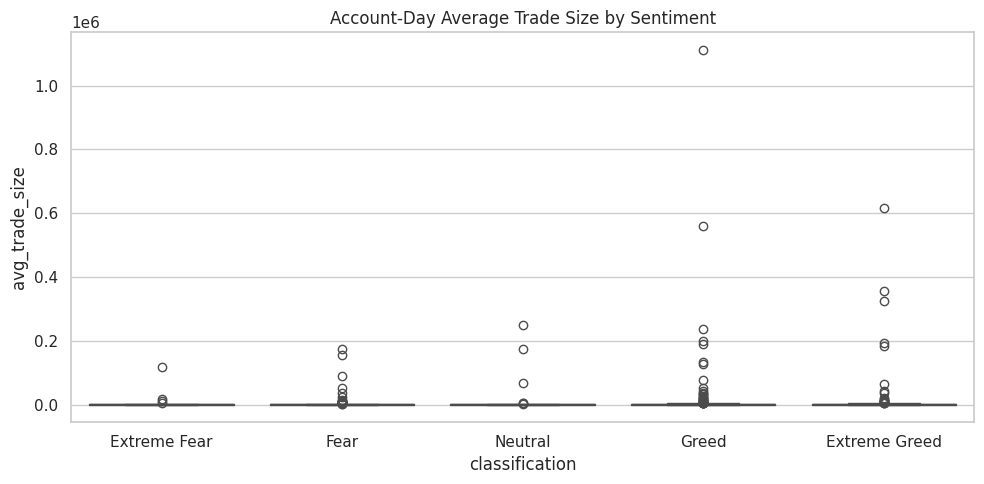

In [9]:
# 6) Descriptives by sentiment class (account-day level)
by_sent = panel.groupby("classification").agg(
    accounts=("account", "nunique"),
    days=("trade_date", "nunique"),
    med_total_pnl=("total_pnl", "median"),
    iqr_total_pnl=("total_pnl", lambda x: np.subtract(*np.percentile(x.dropna(), [75, 25])) if x.notna().any() else np.nan),
    med_profit_rate=("profit_rate", "median"),
    med_norm_trade_pnl=("median_trade_pnl", "median"),
    med_buy_ratio=("buy_ratio", "median"),
    med_trades=("total_trades", "median")
).reset_index()
print(by_sent)

# Plots
plt.figure(figsize=(10,5))
sns.boxplot(data=panel, x="classification", y="total_pnl", order=order)
plt.title("Account-Day Total PnL by Sentiment")
plt.tight_layout()
plt.savefig("box_total_pnl_by_sentiment.png", dpi=180)

plt.figure(figsize=(10,5))
sns.boxplot(data=panel, x="classification", y="profit_rate", order=order)
plt.title("Account-Day Profit Rate by Sentiment")
plt.tight_layout()
plt.savefig("box_profit_rate_by_sentiment.png", dpi=180)

plt.figure(figsize=(10,5))
sns.boxplot(data=panel, x="classification", y="avg_trade_size", order=order)
plt.title("Account-Day Average Trade Size by Sentiment")
plt.tight_layout()
plt.savefig("box_avg_trade_size_by_sentiment.png", dpi=180)

In [10]:
# 7) Kruskal–Wallis for profit_rate and total_pnl across sentiment
samples_profit = [panel.loc[panel["classification"]==lab, "profit_rate"].dropna() for lab in order]
samples_pnl = [panel.loc[panel["classification"]==lab, "total_pnl"].dropna() for lab in order]

kw_profit = stats.kruskal(*samples_profit)  # H, pvalue
kw_pnl = stats.kruskal(*samples_pnl)
print("KW profit_rate:", kw_profit)
print("KW total_pnl:", kw_pnl)

# Dunn post-hoc on profit_rate
# Prepare a DataFrame with the two columns as required by scikit-posthocs
df_dunn = panel[["classification", "profit_rate"]].dropna()
dunn_profit = sp.posthoc_dunn(df_dunn, val_col="profit_rate", group_col="classification", p_adjust="bonferroni")
print("Dunn post-hoc (profit_rate):\n", dunn_profit)

# Dunn post-hoc on total_pnl
df_dunn2 = panel[["classification", "total_pnl"]].dropna()
dunn_pnl = sp.posthoc_dunn(df_dunn2, val_col="total_pnl", group_col="classification", p_adjust="bonferroni")
print("Dunn post-hoc (total_pnl):\n", dunn_pnl)

KW profit_rate: KruskalResult(statistic=np.float64(9.764827366152383), pvalue=np.float64(0.04458104478688198))
KW total_pnl: KruskalResult(statistic=np.float64(93.14164252893339), pvalue=np.float64(2.830674654475346e-19))
Dunn post-hoc (profit_rate):
                Extreme Fear      Fear   Neutral     Greed  Extreme Greed
Extreme Fear       1.000000  0.037607  0.739762  0.027955       0.169405
Fear               0.037607  1.000000  1.000000  1.000000       1.000000
Neutral            0.739762  1.000000  1.000000  1.000000       1.000000
Greed              0.027955  1.000000  1.000000  1.000000       1.000000
Extreme Greed      0.169405  1.000000  1.000000  1.000000       1.000000
Dunn post-hoc (total_pnl):
                Extreme Fear          Fear       Neutral         Greed  \
Extreme Fear   1.000000e+00  9.014821e-10  1.000000e+00  4.010814e-13   
Fear           9.014821e-10  1.000000e+00  2.181455e-08  1.000000e+00   
Neutral        1.000000e+00  2.181455e-08  1.000000e+00  1.6445

In [11]:
# 8) Logistic regression at trade level (optional; can be heavy)
# Filter reasonable rows
merged["pnl_bin"] = (merged["closedpnl"].astype(float) > 0).astype(int) # Recreate pnl_bin
logit_df = merged[["pnl_bin", "sentiment_score", "size", "side_binary", "account"]].dropna()
# Scale size to reduce numeric issues
logit_df["size_scaled"] = (logit_df["size"].abs() / (logit_df["size"].abs().median() + 1e-9)).clip(upper=10)

model = smf.glm("pnl_bin ~ sentiment_score + size_scaled + side_binary",
                data=logit_df, family=sm.families.Binomial()).fit()
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                pnl_bin   No. Observations:                35864
Model:                            GLM   Df Residuals:                    35857
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23207.
Date:                Wed, 17 Sep 2025   Deviance:                       46413.
Time:                        08:16:50   Pearson chi2:                 3.58e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.06915
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.5575 

/tmp/ipython-input-1742687885.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mkt = merged.groupby(["trade_date", "classification"]).agg(


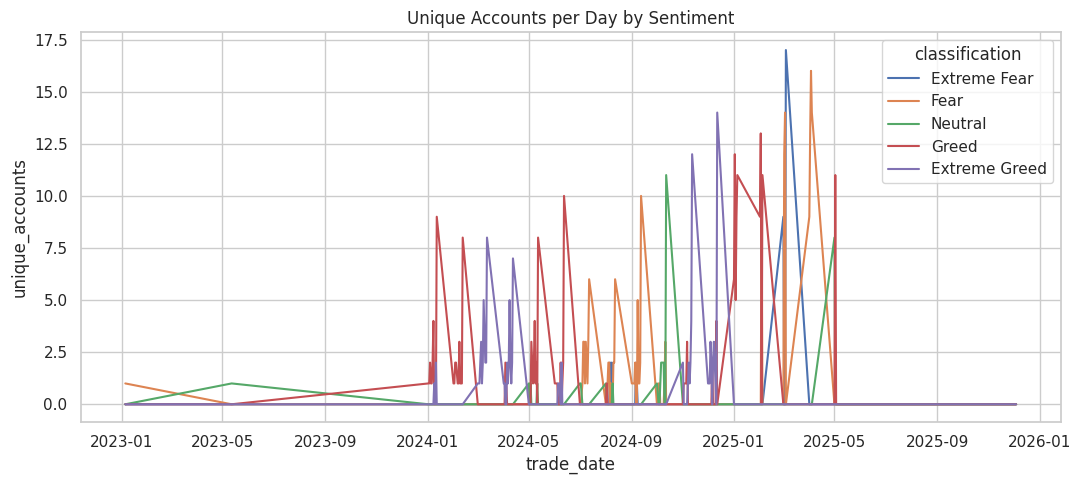

In [12]:
# 9) Market-wide aggregates per day
merged["pnl"] = merged["closedpnl"].astype(float) # Recreate pnl
mkt = merged.groupby(["trade_date", "classification"]).agg(
    unique_accounts=("account", "nunique"),
    total_turnover=("size", lambda x: x.abs().sum() if x.notna().any() else np.nan),
    trades=("pnl", "count")
).reset_index()

# Plot participation
plt.figure(figsize=(11,5))
sns.lineplot(mkt, x="trade_date", y="unique_accounts", hue="classification", hue_order=order)
plt.title("Unique Accounts per Day by Sentiment")
plt.tight_layout()
plt.savefig("line_unique_accounts_by_sentiment.png", dpi=180)

In [13]:
# 10) Exports
merged.to_csv("trades_with_sentiment.csv", index=False)
panel.to_csv("account_day_panel.csv", index=False)
by_sent.to_csv("summary_by_sentiment.csv", index=False)

# Print key insights placeholder
print("Saved: trades_with_sentiment.csv, account_day_panel.csv, summary_by_sentiment.csv")
print("Figures: box_total_pnl_by_sentiment.png, box_profit_rate_by_sentiment.png, box_leverage_by_sentiment.png, line_unique_accounts_by_sentiment.png")

Saved: trades_with_sentiment.csv, account_day_panel.csv, summary_by_sentiment.csv
Figures: box_total_pnl_by_sentiment.png, box_profit_rate_by_sentiment.png, box_leverage_by_sentiment.png, line_unique_accounts_by_sentiment.png


Summary Report: Analysis of Trading Performance and Fear & Greed Index

This notebook analyzes the relationship between trading performance from a Hyperliquid dataset and the cryptocurrency Fear & Greed Index. The analysis is performed in several steps, focusing on data loading, preprocessing, merging, aggregation, statistical testing, and visualization.

1. Data Loading and Initial Setup:

Necessary libraries for data manipulation, analysis, and visualization are imported, including pandas, numpy, matplotlib, and seaborn.
The scikit-posthocs library is installed for post-hoc analysis.
The Hyperliquid historical data (historical_data.csv) is loaded into a pandas DataFrame named hd.
The Fear & Greed Index data (fear_greed_index.csv) is loaded into a pandas DataFrame named fgp.
2. Data Preprocessing and Merging:

Copies of the loaded dataframes (hd and fgp) are created as hl and fg respectively.
Column names in both dataframes are standardized to lowercase with underscores for consistency.
Specific columns in the hl dataframe are renamed to ensure consistent naming (e.g., 'coin' to 'symbol', 'timestamp ist' to 'time', 'closed_pnl' to 'closedpnl').
The 'time' column in the hl dataframe is converted to datetime objects and filtered for valid dates. A 'trade_date' column (UTC date) is created for merging.
If an 'event' column exists in the hl dataframe, the data is filtered to keep only executed trades/fills.
A 'size' column is created in hl, prioritizing 'size_tokens' and falling back to 'size_usd'.
Numeric columns in hl ('execution_price', 'closedpnl', 'start_position') are converted to numeric types. The 'leverage' column was not present and was excluded from analysis.
The 'side' column is normalized, and a binary 'side_binary' column is created (1 for Buy, 0 for Sell).
The 'date' column in the fg dataframe is converted to datetime objects and then to UTC dates.
The primary classification column in fg is identified and standardized.
The 'classification' column in fg is converted to an ordered categorical type with scores assigned based on the fear and greed levels.
Duplicate entries in fg based on date are removed, keeping the latest entry for each date.
The hl and fg dataframes are merged based on the 'trade_date' and 'date' columns, respectively.
3. Trade-Level Features and Aggregation:

A 'pnl' column is created in the merged dataframe from 'closedpnl'.
A binary 'pnl_bin' column is created indicating whether a trade was profitable.
A 'norm_pnl' column is calculated by normalizing 'pnl' by the absolute trade size.
The merged data is grouped by 'account', 'trade_date', 'classification', and 'sentiment_score' to create an account-day aggregated dataframe (agg).
Various metrics are aggregated at the account-day level, including total trades, total PnL, profit rate, median trade PnL, tail risk (5th percentile PnL), total and average trade size, buy ratio, and number of unique symbols traded.
A Herfindahl index for symbol concentration is calculated for each account-day.
The aggregated metrics and symbol concentration are merged into a panel dataframe (panel).
4. Descriptive Analysis and Visualization:

The panel dataframe is grouped by 'classification' to calculate descriptive statistics for each sentiment class (by_sent). These statistics include the number of unique accounts and days, median total PnL, interquartile range of total PnL, median profit rate, median normalized trade PnL, median buy ratio, and median total trades.
Box plots are generated to visualize the distribution of 'total_pnl', 'profit_rate', and 'avg_trade_size' across the different sentiment classifications.
5. Statistical Testing:

Kruskal–Wallis tests are performed on 'profit_rate' and 'total_pnl' to determine if there are statistically significant differences across the sentiment classifications.
Dunn's post-hoc tests with Bonferroni correction are conducted on 'profit_rate' and 'total_pnl' to identify which specific sentiment class pairs have statistically significant differences.
6. Logistic Regression Analysis:

A logistic regression model is built at the trade level to predict the probability of a profitable trade ('pnl_bin') based on 'sentiment_score', 'size_scaled', and 'side_binary'. The 'pnl_bin' column is recreated within this cell to ensure its availability.
7. Market-Wide Aggregates and Participation:

Market-wide aggregates per day are calculated from the merged dataframe, including unique accounts, total turnover (absolute sum of size), and total trades, grouped by 'trade_date' and 'classification'. The 'pnl' column is recreated within this cell for this aggregation.
A line plot is generated to visualize the number of unique accounts participating each day, colored by the sentiment classification.
8. Data Export:

The processed dataframes (merged, panel, and by_sent) are saved to CSV files for further use or analysis.
The filenames of the saved data and generated figures are printed.
Overall, this notebook provides a comprehensive analysis of how the Fear & Greed Index relates to various aspects of trading performance at both the account-day and market-wide levels, employing descriptive statistics, visualizations, non-parametric statistical tests, and a logistic regression model.